<a href="https://colab.research.google.com/github/lipeng2021/-python1/blob/main/5_5_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torch.nn as nn
from IPython import display
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import sys
import time
FILENAME = '/home/lp'
device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')

In [29]:
mnist_train = torchvision.datasets.FashionMNIST(root=FILENAME,train=True,transform=transforms.ToTensor(),download=True)
mnist_test = torchvision.datasets.FashionMNIST(root=FILENAME,train=False,transform=transforms.ToTensor(),download=True)

In [30]:
def get_fashion_labels(labels):
  display.set_matplotlib_formats('svg')
  plt.rcParams['figure.figsize']=(12,12)
  text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','sneaker','bag','ankle','boot']
  return (text_labels[int(i)]for i in labels)
def show_fashion_mnist(images,labels):
  _,img = plt.subplots(1,len(images),figsize=(12,12))
  for i,img,lbl in zip(img,images,labels):
    i.imshow(img.view(28,28).numpy())
    i.set_title(lbl)
    i.axes.get_xaxis().set_visible(True)
    i.axes.get_yaxis().set_visible(True)
  plt.show()

In [ ]:
x =[]
y =[]
for i in range(5):
  x.append(mnist_train[i][0])
  y.append(mnist_train[i][1])
show_fashion_mnist(x,get_fashion_labels(y))

In [32]:
from torch.nn.modules.pooling import MaxPool2d
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.conv = nn.Sequential(
          nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
          nn.Sigmoid(),
          nn.MaxPool2d(kernel_size=2,stride=2),
          nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
          nn.Sigmoid(),
          nn.MaxPool2d(kernel_size=2,stride=2)    
    )
    self.fc = nn.Sequential(
          nn.Linear(in_features=16*4*4,out_features=120),
          nn.Sigmoid(),
          nn.Linear(in_features=120,out_features=84),
          nn.Sigmoid(),
          nn.Linear(in_features=84,out_features=10),
    )
  def forward(self,image):
    feature = self.conv(image)
    output = self.fc(feature.view(image.shape[0],-1))
    return output

In [33]:
net = LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [34]:
batch_size = 256
if sys.platform.startswith('win'):
  num_workers = 0
else:
  num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [35]:
def evaculate_accuracy(data_iter,net,device=torch.device('cuda'if torch.cuda.is_available()else 'cpu')):
  acc_sum=0.0
  n = 0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net,torch.nn.Module):
        net.eval()
        acc_sum +=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
        net.train()
      else:
        if('is_training'in net.__code__.co_varnames):
          acc_sum +=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
        else:
          acc_sum +=(net(X).argmax(dim=1)==y).float().sum().item()
      n += y.shape[0]
  return acc_sum/n

In [36]:
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
  net = net.to(device)
  print('training on:',device)
  loss = torch.nn.CrossEntropyLoss()
  batch_cout =0
 

  for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc_sum = 0.0
    n = 0
    start = time.time()
    for X,y in train_iter:
      X=X.to(device)
      y = y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_loss += l.cpu().item()
      train_acc_sum +=(net(X).argmax(dim=1)==y).float().sum().cpu().item()
      n += y.shape[0]
      batch_cout +=1
    test_acc_sum = evaculate_accuracy(test_iter,net)
    print('epopch:%d,loss:%.4f,train_acc:%.3f,test_acc:%.3f,time:%.1f'%(epoch+1,train_loss/batch_cout,train_acc_sum/n,test_acc_sum,time.time()-start))

In [37]:
lr =0.001
num_epochs = 5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on: cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epopch:1,loss:1.8947,train_acc:0.305,test_acc:0.581,time:8.9
epopch:2,loss:0.4669,train_acc:0.655,test_acc:0.700,time:9.0
epopch:3,loss:0.2478,train_acc:0.725,test_acc:0.730,time:8.8
epopch:4,loss:0.1657,train_acc:0.747,test_acc:0.749,time:8.8
epopch:5,loss:0.1226,train_acc:0.760,test_acc:0.757,time:9.2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


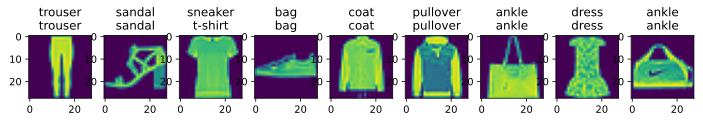

In [58]:
X1,y = iter(test_iter).next()
X1=X1.to(device)
true_labels = get_fashion_labels(y.numpy())
pred_labels = get_fashion_labels(net(X1).argmax(dim=1).cpu().numpy())
title = [true+'\n'+pred for true,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X1[0:9].cpu(),title[0:9])